In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### prep Data

In [22]:
europe_or_nearby = ['Austria', 'Belarus', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands',
       'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania',
       'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom']

In [23]:
distance = pd.read_csv('data/controls/distance.csv', index_col=0)
subsidies = pd.read_csv('data/controls/energy_subsidies.csv', index_col=0)
urss = pd.read_csv('data/controls/ex_urss_influenced.csv', index_col=0)
gdppc = pd.read_csv('data/controls/GDPperCap.csv', index_col=0)
unemployment = pd.read_csv('data/controls/unemployment.csv', index_col=0)

In [24]:
# keep change in subsidies from 2021 to 2022
subsidies['increase'] = subsidies['2022'] - subsidies['2021']
subsidies = subsidies[['increase']].rename(columns={'increase': 'energy_subsidies_increase'})

In [25]:
# will talke 2022 (not the change), to account for country economic disparities

# keep only countries in Europe or nearby for gdppc
gdppc = gdppc.loc[gdppc.index.isin(europe_or_nearby)]
gdppc = gdppc[['2022']].rename(columns={'2022': 'gdppc'})

In [26]:
unemployment = unemployment.loc[unemployment.index.isin(europe_or_nearby)]
unemployment['increase'] = unemployment['2022'] - unemployment['2021']
unemployment = unemployment[['2022']].rename(columns={'2022': 'unemployment_increase'})

In [27]:
bartik = pd.read_csv('data/FINAL_BARTIK.csv', index_col=0)

In [28]:
approvals = pd.read_csv('../Design/data/Approvals_cleaned.csv')
approvals.drop(columns=['Sweden', 'Italy', 'United Kingdom'], inplace=True)

def compute_approval_change(start_date, end_date):
    df = approvals.copy()
    df['Date'] = pd.to_datetime(df['Date'])  # ensure datetime format

    # Convert wide to long format
    df_long = df.melt(id_vars='Date', var_name='country', value_name='approval')

    # Filter date range
    df_long = df_long[(df_long['Date'] >= start_date) & (df_long['Date'] <= end_date)]

    # Calculate change from start to end per country
    start_approvals = df_long[df_long['Date'] == pd.to_datetime(start_date)]
    end_approvals = df_long[df_long['Date'] == pd.to_datetime(end_date)]

    merged = pd.merge(start_approvals, end_approvals, on='country', suffixes=('_start', '_end'))
    merged['approval_change'] = merged['approval_end'] - merged['approval_start']

    return merged[['country', 'approval_change']]

approval_change = compute_approval_change('2022-06-01', '2022-12-01').dropna()

In [29]:
approval_change.index = approval_change['country']
approval_change = approval_change[['approval_change']]

In [40]:
approval_change.to_csv('data/approval_change_2022.csv')

### Merge all together

In [30]:
# merge all controls into one DataFrame
dataset = distance.join(subsidies).join(gdppc).join(unemployment).join(bartik).join(approval_change) # . join(urss)

In [31]:
dataset.dropna(inplace=True)

In [32]:
# normalize the controls exept for the approval change and ex_urss_influenced
for col in dataset.columns:
    if col not in ['approval_change']:
        dataset[col] = (dataset[col] - dataset[col].mean()) / dataset[col].std()

dataset

,distance_to_kyiv_km,energy_subsidies_increase,gdppc,unemployment_increase,bartik_iv,approval_change
country,,,,,,
Austria,-0.680828,-0.306593,0.141614,-0.182295,-0.422813,-3.0
Belgium,0.464231,-0.649561,0.100734,0.031529,-0.103238,-5.0
Bulgaria,-0.730695,1.293925,-1.008635,-0.450129,0.600250,-8.0
Croatia,-0.477275,0.036375,-0.864694,0.545740,-0.144016,1.0
Czechia,-0.551055,-0.763883,-0.571669,-1.206279,1.281493,-6.0
Denmark,-0.279700,-0.649561,0.616689,-0.388719,-0.858533,-3.0
Estonia,-0.667559,-0.192270,-0.566626,0.031899,1.413947,-2.0
Finland,-0.562429,-0.649561,0.089727,0.456586,-0.703323,0.0
France,0.738211,0.379343,-0.189553,0.674478,-0.931966,-6.0


In [33]:
dataset.index.unique()

Index(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Czechia', 'Denmark',
       'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary',
       'Ireland', 'Luxembourg', 'Netherlands', 'Norway', 'Poland', 'Portugal',
       'Romania', 'Slovakia', 'Spain', 'Switzerland'],
      dtype='object', name='country')

/tmp/ipykernel_23564/2986858519.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


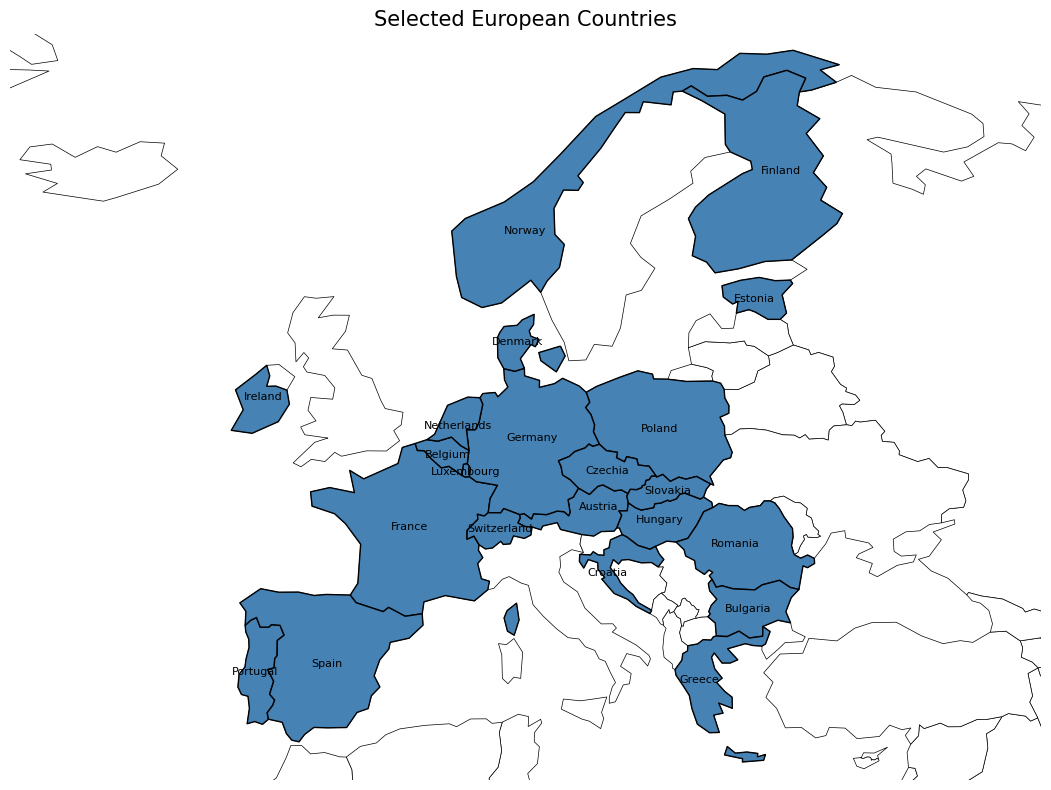

In [34]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Mark countries in the dataset
world['in_dataset'] = world['name'].isin(dataset.index)

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Plot all countries in white
world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Highlight only countries in the dataset
highlighted = world[world['in_dataset']]
highlighted.plot(ax=ax, color='steelblue', edgecolor='black')

# Add labels (with manual correction for Norway)
for idx, row in highlighted.iterrows():
    name = row['name']

    if name == "Norway":
        # Manually place the label lower
        ax.text(10, 62, "Norway", fontsize=8, ha='center', va='center')
    else:
        point = row['geometry'].representative_point()
        ax.text(point.x, point.y, name, fontsize=8, ha='center', va='center')


# Zoom in on Europe
ax.set_xlim(-25, 45)
ax.set_ylim(34, 72)

# Style
ax.set_title('Selected European Countries', fontsize=15)
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [35]:
dataset.head(2)

,distance_to_kyiv_km,energy_subsidies_increase,gdppc,unemployment_increase,bartik_iv,approval_change
country,,,,,,
Austria,-0.680828,-0.306593,0.141614,-0.182295,-0.422813,-3.0
Belgium,0.464231,-0.649561,0.100734,0.031529,-0.103238,-5.0


In [36]:
# regress approval_change on pca_controls and bartik
import statsmodels.api as sm
X = dataset[['bartik_iv']]
X = sm.add_constant(X)  # add constant term for intercept
model = sm.OLS(dataset['approval_change'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        approval_change   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     4.250
Date:                Tue, 08 Jul 2025   Prob (F-statistic):             0.0525
Time:                        17:03:36   Log-Likelihood:                -59.127
No. Observations:                  22   AIC:                             122.3
Df Residuals:                      20   BIC:                             124.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5909      0.795     -4.516      0.0

In [37]:
# regress approval_change on pca_controls and bartik
import statsmodels.api as sm
X = dataset[['bartik_iv', 'gdppc']]
X = sm.add_constant(X)  # add constant term for intercept
model = sm.OLS(dataset['approval_change'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        approval_change   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.044
Date:                Tue, 08 Jul 2025   Prob (F-statistic):              0.157
Time:                        17:03:36   Log-Likelihood:                -59.103
No. Observations:                  22   AIC:                             124.2
Df Residuals:                      19   BIC:                             127.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5909      0.815     -4.406      0.0

In [38]:
# regress approval_change on pca_controls and bartik
import statsmodels.api as sm
X = dataset[['bartik_iv', 'gdppc', 'energy_subsidies_increase', 'distance_to_kyiv_km']]
X = sm.add_constant(X)  # add constant term for intercept
model = sm.OLS(dataset['approval_change'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        approval_change   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1.239
Date:                Tue, 08 Jul 2025   Prob (F-statistic):              0.332
Time:                        17:03:36   Log-Likelihood:                -58.432
No. Observations:                  22   AIC:                             126.9
Df Residuals:                      17   BIC:                             132.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 